In [1]:
import pandas, numpy, seaborn, scipy

In [2]:
import sklearn, sklearn.preprocessing
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.8, 9 * 0.8)})

In [4]:
input_data_file = '/Users/adrian/gd15/research/vigur/data/targeted.2024.eva/EC_72_EVA_All_ION_MODES.xlsx'

In [5]:
negativedf = pandas.read_excel(input_data_file, sheet_name='ACID_NEG', index_col='SAMPLE')

# batch & replicate 3

In [6]:
wdf = negativedf[negativedf['LCMS_BATCH'] == 3]

['Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool']
['Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool']


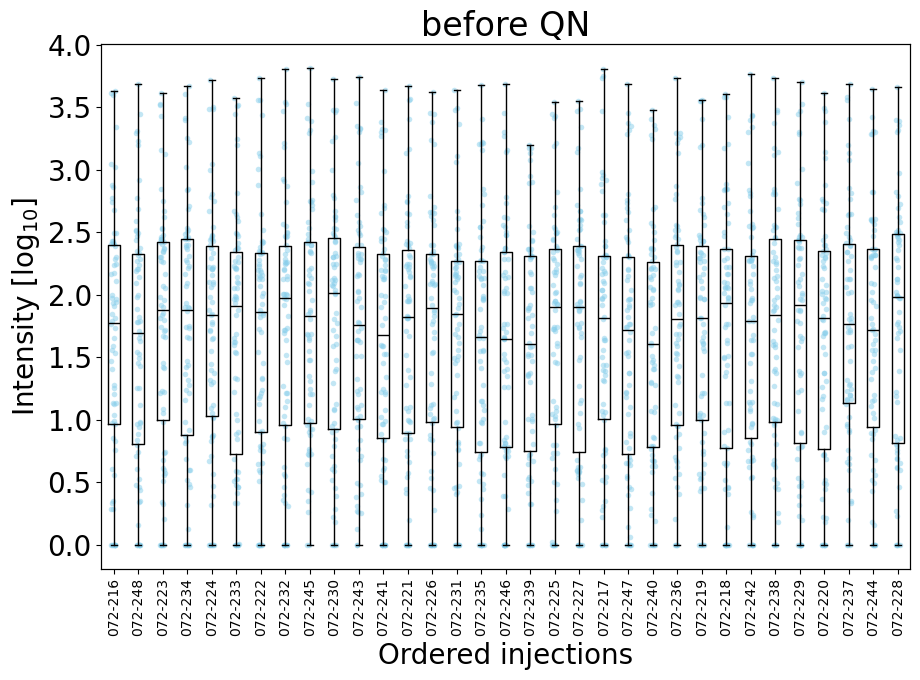

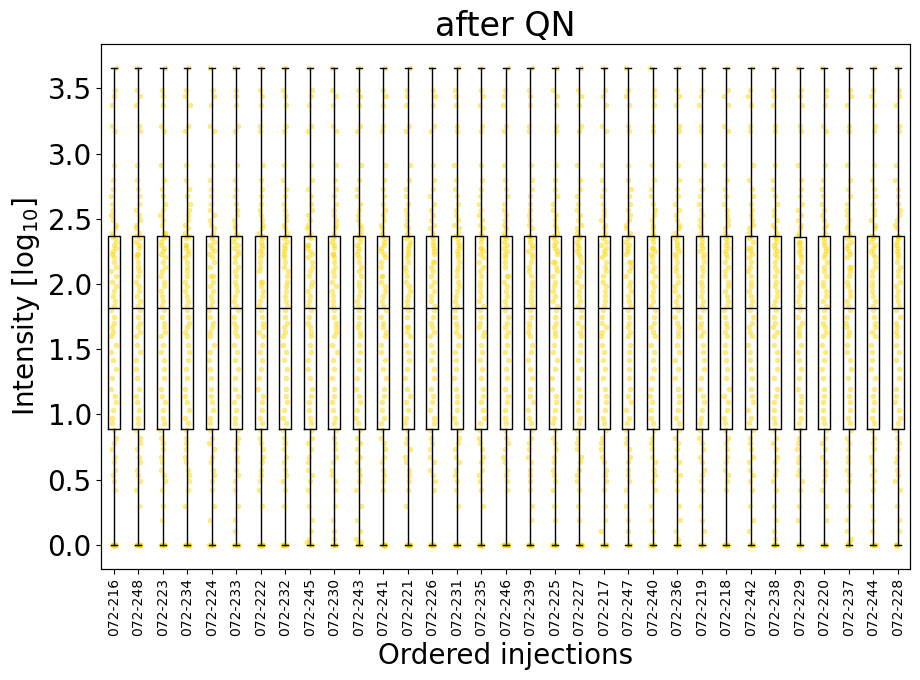

In [7]:
# transform
intensities = wdf.iloc[:, 6:]

rocks = []
for label in wdf.index:
    if isinstance(label, str) == False:
        rocks.append(label)
    else:
        if '072' not in label:
            rocks.append(label)  
print(rocks)
# some rocks that failed
print(rocks)
#
intensities.drop(rocks, axis=0, inplace=True)

intensities = intensities.transpose()
log10_intensities = numpy.log10(intensities + 1)

#plot
ax1 = log10_intensities.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(log10_intensities, color='skyblue', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('before QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10_intensities.values, axis=0), 
                             index=log10_intensities.index, 
                             columns=log10_intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10_intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

# plot after
ax1 = df_qn.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_qn, color='gold', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('after QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

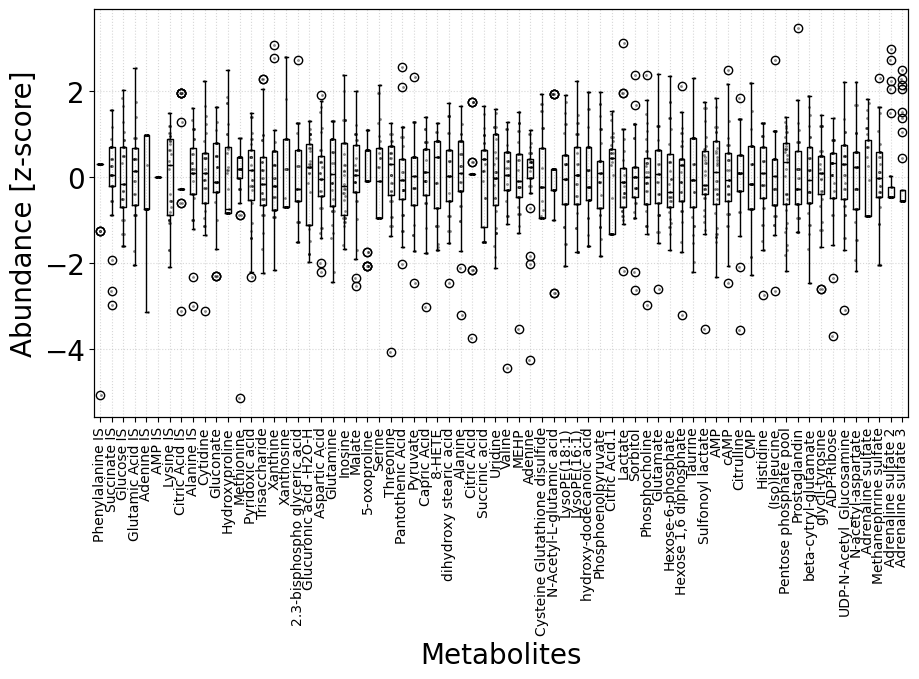

In [8]:
# transpose & scale
t_df_qn = df_qn.transpose()
std_scaler = sklearn.preprocessing.StandardScaler()
df_std = pandas.DataFrame(std_scaler.fit_transform(t_df_qn), columns=t_df_qn.columns, index=t_df_qn.index)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [9]:
print(log10_intensities.loc['AMP IS'].values)
print(df_qn.loc['AMP IS'].values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
print(log10_intensities.loc['Lactate'].values)
print(df_qn.loc['Lactate'].values)

[2.88098785 2.33200799 2.44285589 2.38390329 2.44809076 2.62570746
 2.41382931 2.49268777 2.5353916  2.4210426  2.54861419 2.36416624
 2.40491578 2.35070146 2.52863779 2.37996326 2.37212367 2.28450969
 2.28063982 2.37481981 2.9618087  2.66088824 2.57528024 2.24126001
 2.40280456 2.88637452 2.53427112 2.55870617 2.42279332 1.97145213
 2.64275033 2.5155374  2.42343102]
[2.91440554 2.37103594 2.45302905 2.27241212 2.45302905 2.67648315
 2.52655154 2.48664614 2.45302905 2.32330199 2.52655154 2.39392273
 2.42924708 2.39392273 2.72801039 2.45302905 2.39392273 2.30181323
 2.27241212 2.32330199 3.17585861 2.61107561 2.72801039 2.23299652
 2.37103594 2.91440554 2.45302905 2.52655154 2.30181323 1.98450534
 2.56457629 2.45302905 2.25541105]


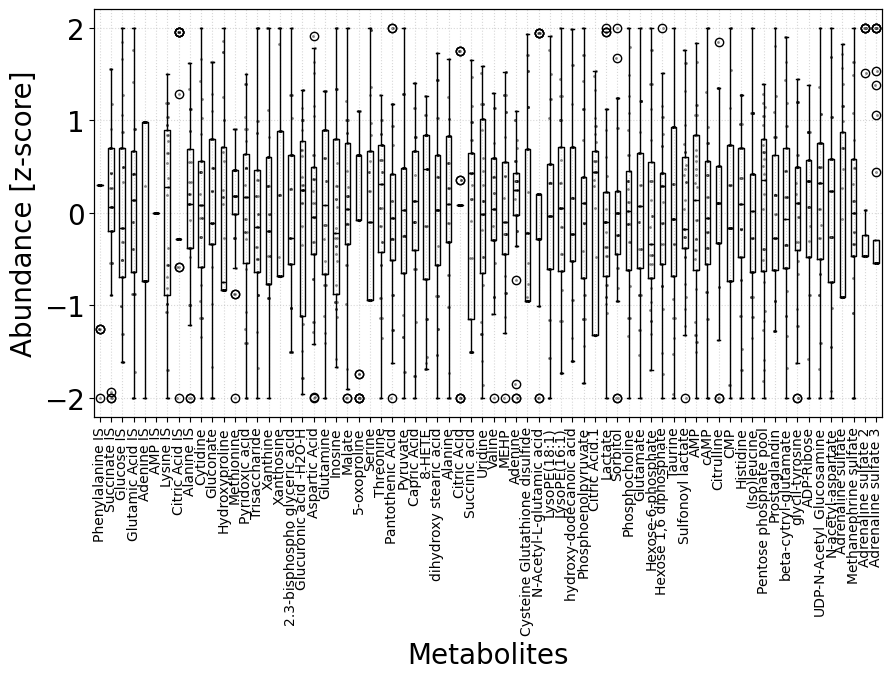

In [11]:
# clip
df_std.clip(-2, 2, inplace=True)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

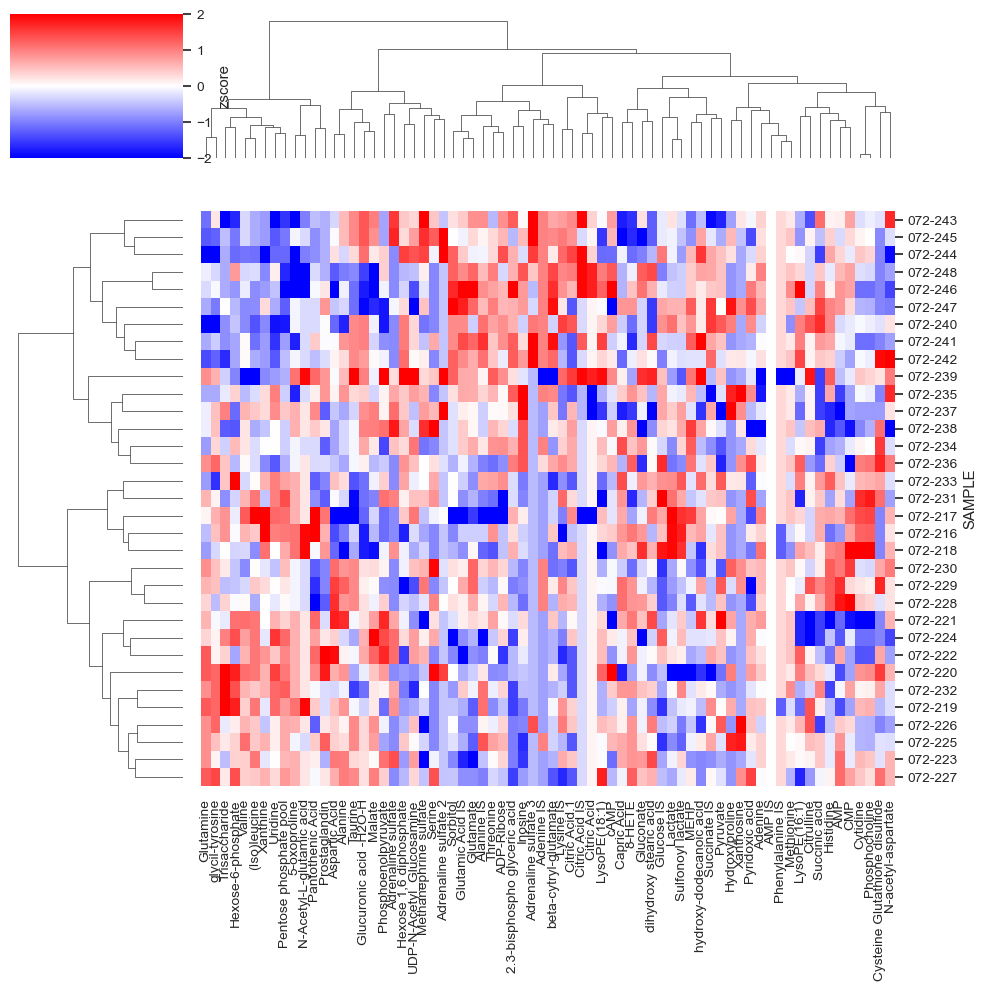

In [12]:
# visualize pattern
linkage_method = 'ward'
distance_metric = 'euclidean'

seaborn.set(font_scale=0.9)
seaborn.clustermap(df_std, 
                   cmap='bwr', col_cluster=True, vmin=-2, vmax=2, 
                   method=linkage_method, metric=distance_metric, 
                   yticklabels=1, xticklabels=1,
                   cbar_kws={'label':'zscore'})
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

seaborn.reset_orig()

In [13]:
print(df_std['Alanine IS'].mean())
print(df_std['Alanine IS'].std())

0.03980177063739461
0.9119716389241839


Timepoint 4
	 Phenylalanine IS
	 Succinate IS
	 Glucose IS
	 Glutamic Acid IS
	 Adenine IS
		 [-0.73834671 -0.73834671 -0.73834671] [0.9777216 0.9777216 0.9777216] 2.6278095464664316e-65
	 AMP IS
	 Lysine IS
	 Citric Acid IS
	 Alanine IS
	 Cytidine
	 Gluconate
	 Hydroxyproline
	 Methionine
	 Pyridoxic acid
	 Trisaccharide
	 Xanthine
	 Xanthosine
	 2.3-bisphospho glyceric acid
	 Glucuronic acid -H2O-H
	 Aspartic Acid
	 Glutamine
	 Inosine
	 Malate
	 5-oxoproline
		 [0.62499588 1.10069363 0.62499588] [-0.08140349 -0.08140349 -0.08140349] 0.00548859676886008
	 Serine
	 Threonine
	 Pantothenic Acid
		 [1.17949882 0.4209426  0.93292256] [-1.26191043 -1.62572325 -2.        ] 0.0013159707726529341
	 Pyruvate
	 Capric Acid
	 8-HETE
	 dihydroxy stearic acid
	 Alanine
	 Citric Acid
	 Succinic acid
	 Uridine
		 [0.59378103 1.17433329 1.50530143] [-0.48014124 -0.01072123 -0.18462749] 0.011746427524370712
	 Valine
		 [1.12784717 0.3888184  1.12784717] [-0.91157285 -0.29893873  0.04554171] 0.0271349

/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531

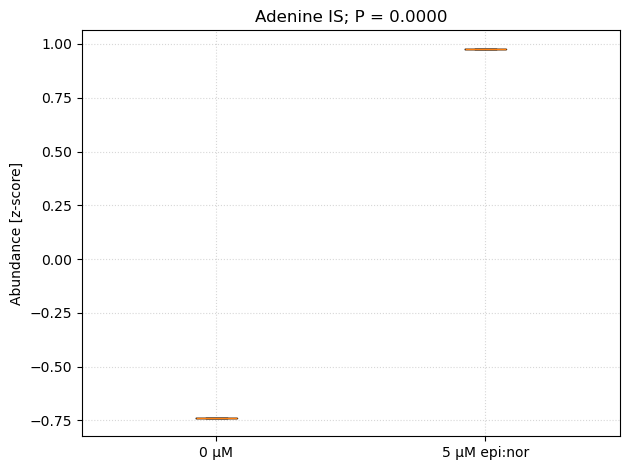

Pantothenic Acid 0.03070598469523513


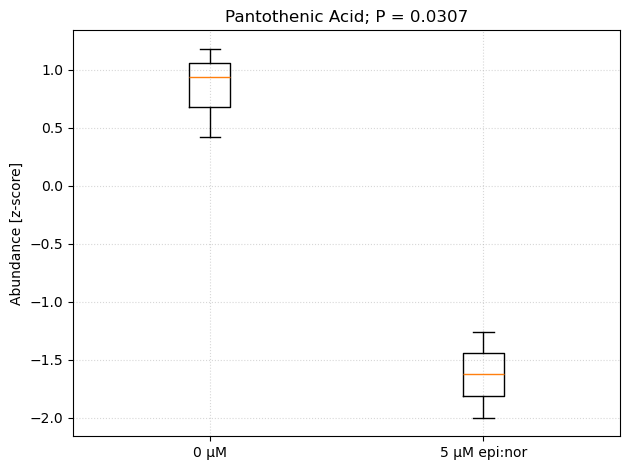

Hexose-6-phosphate 0.03253204170608247


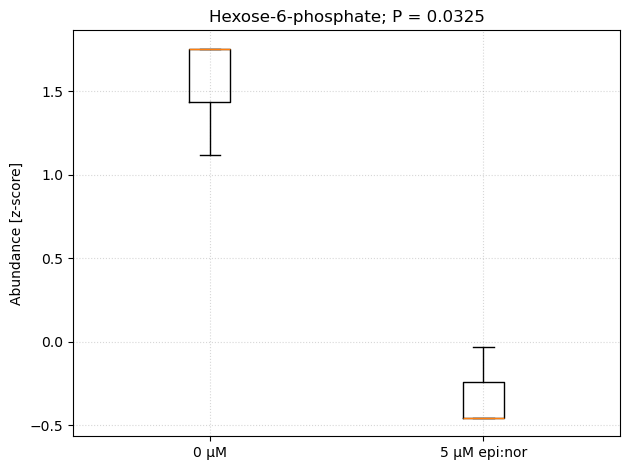

AMP 0.011243870902960631


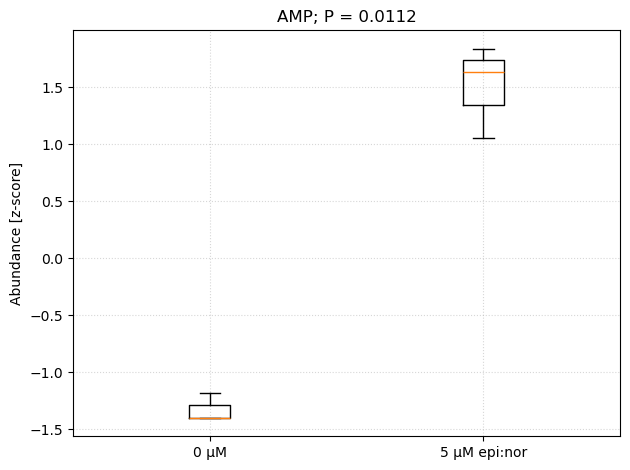

Timepoint 24
	 Phenylalanine IS
	 Succinate IS
	 Glucose IS
	 Glutamic Acid IS
	 Adenine IS
	 AMP IS
	 Lysine IS
	 Citric Acid IS
	 Alanine IS
	 Cytidine
	 Gluconate
	 Hydroxyproline
	 Methionine
	 Pyridoxic acid
		 [0.29613246 0.89937744 1.39146351] [-1.40698673 -0.06921681 -0.28551703] 0.04990501697529428
	 Trisaccharide
	 Xanthine
	 Xanthosine
	 2.3-bisphospho glyceric acid
	 Glucuronic acid -H2O-H
		 [0.67783774 0.38966611 0.10954557] [1.32042709 1.32042709 1.13233393] 0.007888091275999102
	 Aspartic Acid
	 Glutamine
	 Inosine
		 [1.33736611 2.         1.33736611] [ 0.5411766   0.05923298 -0.27725817] 0.011055220076356695
	 Malate
	 5-oxoproline
	 Serine
	 Threonine
	 Pantothenic Acid
		 [-0.28590032  0.128632   -0.28590032] [-0.88681874 -0.50481751 -0.88681874] 0.03120535449398134
	 Pyruvate
	 Capric Acid
	 8-HETE
		 [0.47075991 0.84161378 1.26378306] [-1.68269723 -1.62112837 -1.14348335] 0.0012052098812484347
	 dihydroxy stearic acid
		 [ 0.03378571 -0.56335082  0.03378571] [-1.2

/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531

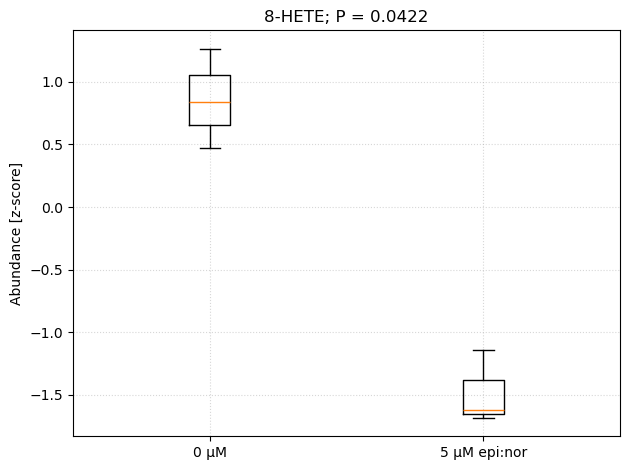

Adrenaline sulfate 3 0.007647647363964178


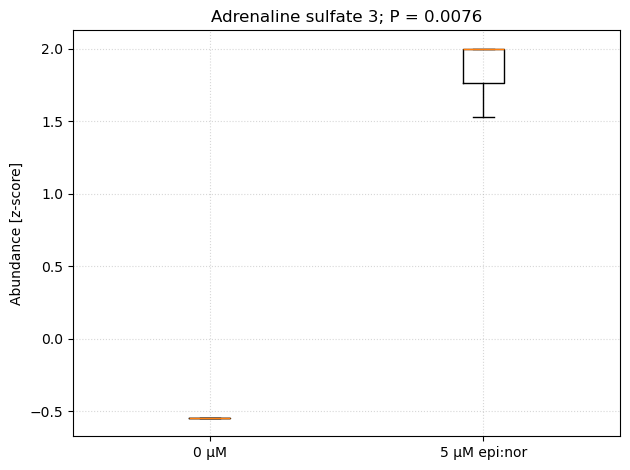

In [14]:
# test
timepoints = [4, 24]
timepoints = [4, 24]
control_label = '0µM'
sample_label = '5 µM epi:nor'
metabolites = df_std.columns

for timepoint in timepoints:
    print('Timepoint {}'.format(timepoint))
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == control_label)
    controls = wdf[rules].index.to_list()
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == sample_label)
    samples = wdf[rules].index.to_list()

    uncorrected = []
    for metabolite in metabolites:
        print('\t', metabolite)
        existing = [control for control in controls if control in df_std.index]
        x = df_std.loc[existing, metabolite]
        existing = [sample for sample in samples if sample in df_std.index]
        y = df_std.loc[samples, metabolite]

        (statistic, pvalue) = scipy.stats.ttest_ind(x, y)
        if numpy.isnan(pvalue) == True:
            pvalue = 1
        uncorrected.append(pvalue)
        if pvalue < 0.05:
            print('\t\t', x.values, y.values, pvalue)
    results = statsmodels.stats.multitest.multipletests(uncorrected, method='fdr_bh')
    print('We found significant metabolites:', sum(results[0]))
    print(results)

    # plot significant
    for i in range(len(metabolites)):
        if results[0][i] == True:
            print(metabolites[i], results[1][i])
            metabolite = metabolites[i]
            a = df_std.loc[controls, metabolite]
            b = df_std.loc[samples, metabolite]
            matplotlib.pyplot.boxplot([a, b])
            matplotlib.pyplot.title('{}; P = {:.4f}'.format(metabolite, results[1][i]))
            matplotlib.pyplot.xticks([1, 2], ['0 µM', '5 µM epi:nor'])
            matplotlib.pyplot.ylabel('Abundance [z-score]')
            matplotlib.pyplot.grid(ls=':', alpha=0.5)
            matplotlib.pyplot.tight_layout()
            matplotlib.pyplot.show()